## 1–2) Acquire & Load MNIST into a Pandas DataFrame

In [1]:

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

def get_mnist():
    """Download MNIST 70k from OpenML and return X, y as numpy arrays.
    X: (70000, 784) float32; y: (70000,) strings '0'..'9'.
    """
    mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='pandas')
    X = mnist['data'].astype(np.float32)
    y = mnist['target'].astype(str)
    return X, y

def to_dataframe(X, y):
    cols = [f"px_{i}" for i in range(X.shape[1])]
    df = pd.DataFrame(X, columns=cols)
    df['label'] = y
    return df

X, y = get_mnist()
df = to_dataframe(X, y)
df.head()


,px_0,px_1,px_2,px_3,px_4,px_5,px_6,px_7,px_8,px_9,...,px_775,px_776,px_777,px_778,px_779,px_780,px_781,px_782,px_783,label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9


## 3) Data Exploration

In [2]:

def summarize(df):
    n_samples = df.shape[0]
    n_features = df.shape[1] - 1
    classes = sorted(df['label'].unique().tolist())
    print("\n=== Data Summary ===")
    print(f"Total samples: {n_samples}")
    print(f"Total features (pixels): {n_features}")
    print(f"Target classes: {classes}")    
    print("\nClass distribution (counts):")
    print(df['label'].value_counts().sort_index())

summarize(df)



=== Data Summary ===
Total samples: 70000
Total features (pixels): 784
Target classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

Class distribution (counts):
label
0    6903
1    7877
2    6990
3    7141
4    6824
5    6313
6    6876
7    7293
8    6825
9    6958
Name: count, dtype: int64


## 4) Visualization — Sample Digit Images

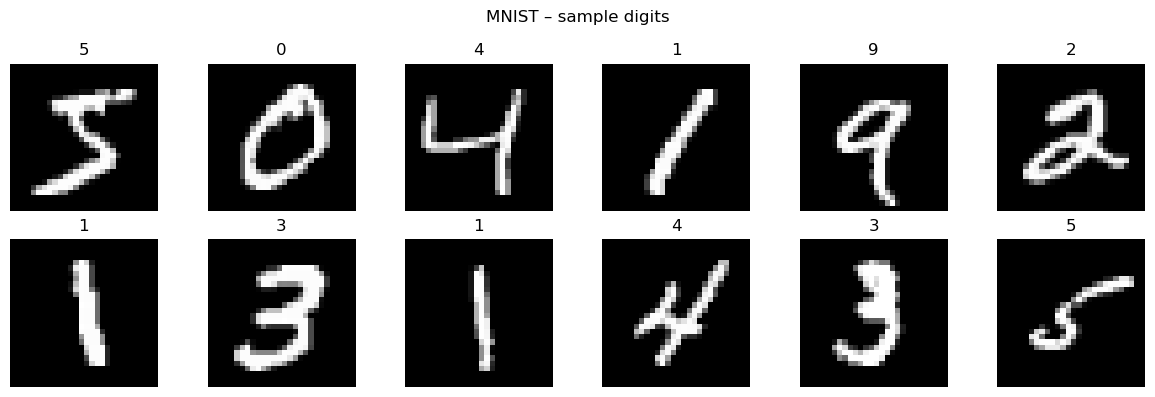

In [3]:

def show_sample_digits(X, y, n=12, title="MNIST – sample digits"):
    assert X.shape[1] == 784, "Expected flattened 28x28 images."
    n = min(n, X.shape[0])
    cols = 6
    rows = int(np.ceil(n / cols))
    plt.figure(figsize=(cols*2, rows*2))
    for i in range(n):
        img = X[i].reshape(28, 28)
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(str(y[i]))
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_sample_digits(X, y, n=12)


## 5) Preprocessing — Train/Test Split & Scaling

In [4]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def preprocess(X, y, test_size=0.2, random_state=RANDOM_STATE):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=random_state
    )
    scaler = StandardScaler(with_mean=True, with_std=True)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

X_train, X_test, y_train, y_test, scaler = preprocess(X, y, test_size=0.2)
X_train.shape, X_test.shape


((56000, 784), (14000, 784))

## 6) Define Models

In [5]:

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC  # linear SVM (fast for high dims)
from sklearn.tree import DecisionTreeClassifier

def make_models():
    models = {
        "logreg": LogisticRegression(
            multi_class="multinomial", solver="saga", max_iter=2000, random_state=RANDOM_STATE, n_jobs=-1
        ),
        "svm_linear": LinearSVC(random_state=RANDOM_STATE),
        "dtree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    }
    return models

models = make_models()
list(models.keys())


['logreg', 'svm_linear', 'dtree']

## 7) Hyperparameter Tuning (Grid Search with Stratified K-Fold)

In [6]:

from sklearn.model_selection import GridSearchCV, StratifiedKFold

def get_param_grids():
    return {
        "logreg": {"C": [0.1, 0.5, 1.0, 2.0], "penalty": ["l2", "l1"]},
        "svm_linear": {"C": [0.5, 1.0, 2.0]},
        "dtree": {
            "max_depth": [None, 10, 20, 30],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4],
        },
    }

def tune_models(models, X_train, y_train, cv=3):
    tuned, best_estimators = {}, {}
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_STATE)
    for name, model in models.items():
        print(f"\n>>> Tuning {name} ...")
        params = get_param_grids()[name]
        gs = GridSearchCV(model, params, scoring="accuracy", n_jobs=-1, cv=skf, verbose=1)
        gs.fit(X_train, y_train)
        tuned[name] = gs
        best_estimators[name] = gs.best_estimator_
        print(f"Best params for {name}: {gs.best_params_}")
        print(f"Best CV accuracy for {name}: {gs.best_score_:.4f}")
    return tuned, best_estimators

tuned, best_estimators = tune_models(models, X_train, y_train, cv=3)
best_estimators



>>> Tuning logreg ...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best params for logreg: {'C': 1.0, 'penalty': 'l1'}
Best CV accuracy for logreg: 0.9197

>>> Tuning svm_linear ...
Fitting 3 folds for each of 3 candidates, totalling 9 fits


KeyboardInterrupt: 

## 8) Training Evaluation (Confusion Matrix, Accuracy, Precision, Recall, F1)

In [ ]:

from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    precision_recall_fscore_support
)

def evaluate(model, X, y, title="Evaluation"):
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    prec_w, rec_w, f1_w, _ = precision_recall_fscore_support(y, y_pred, average='weighted', zero_division=0)
    prec_m, rec_m, f1_m, _ = precision_recall_fscore_support(y, y_pred, average='macro', zero_division=0)

    print(f"\n=== {title} ===")
    print(f"Accuracy: {acc:.4f}")
    print("Classification report (weighted):")
    print(classification_report(y, y_pred, digits=4))

    cm = confusion_matrix(y, y_pred, labels=[str(i) for i in range(10)])
    return {
        "accuracy": acc,
        "precision_weighted": prec_w,
        "recall_weighted": rec_w,
        "f1_weighted": f1_w,
        "precision_macro": prec_m,
        "recall_macro": rec_m,
        "f1_macro": f1_m,
        "confusion_matrix": cm,
        "y_pred": y_pred,
    }

def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(7,6))
    plt.imshow(cm, aspect='auto')
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.colorbar()
    plt.xticks(ticks=range(len(labels)), labels=labels)
    plt.yticks(ticks=range(len(labels)), labels=labels)
    plt.tight_layout()
    plt.show()

train_results = {}
for name, est in best_estimators.items():
    train_results[name] = evaluate(est, X_train, y_train, title=f"{name} – Train")
train_results.keys()


## 9) Testing Evaluation + Bootstrap 95% Confidence Intervals

In [ ]:

from tqdm import tqdm

test_results = {}
for name, est in best_estimators.items():
    test_results[name] = evaluate(est, X_test, y_test, title=f"{name} – Test")
    labels = [str(i) for i in range(10)]
    plot_confusion_matrix(test_results[name]['confusion_matrix'], labels, f"{name} – Test Confusion Matrix")

def bootstrap_metrics(model, X_test, y_test, n_boot=300, random_state=RANDOM_STATE):
    rng = np.random.default_rng(random_state)
    N = len(y_test)
    accs, precs, recs, f1s = [], [], [], []
    for _ in tqdm(range(n_boot), desc="Bootstrapping"):
        idx = rng.integers(0, N, size=N)
        y_true_b = np.array(y_test)[idx]
        y_pred_b = model.predict(X_test[idx])
        accs.append(accuracy_score(y_true_b, y_pred_b))
        p, r, f1, _ = precision_recall_fscore_support(y_true_b, y_pred_b, average='weighted', zero_division=0)
        precs.append(p); recs.append(r); f1s.append(f1)
    def ci(a):
        lo, hi = np.percentile(a, [2.5, 97.5])
        return float(np.mean(a)), float(lo), float(hi)
    return {
        "accuracy_mean_ci": ci(accs),
        "precision_weighted_mean_ci": ci(precs),
        "recall_weighted_mean_ci": ci(recs),
        "f1_weighted_mean_ci": ci(f1s),
    }

test_bootstrap = {name: bootstrap_metrics(est, X_test, y_test, n_boot=300) for name, est in best_estimators.items()}

print("\n=== Bootstrapped 95% CIs on Test (mean, 2.5%, 97.5%) ===")
for name, summ in test_bootstrap.items():
    print(f"\n{name}:")
    for k, v in summ.items():
        mean, lo, hi = v
        print(f"  {k}: mean={mean:.4f}, 95% CI=({lo:.4f}, {hi:.4f})")


## 10) Model Comparison & Over/Underfitting Notes

In [ ]:

def compare_models(train_results, test_results):
    rows = []
    for name in test_results.keys():
        tr = train_results[name]; te = test_results[name]
        rows.append({
            "model": name,
            "train_acc": tr['accuracy'],
            "test_acc": te['accuracy'],
            "train_f1_w": tr['f1_weighted'],
            "test_f1_w": te['f1_weighted'],
        })
    df = pd.DataFrame(rows).sort_values("test_acc", ascending=False)
    print("\n=== Model Comparison (sorted by test accuracy) ===")
    print(df.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

    print("\nNotes on potential over/underfitting:")
    for _, r in df.iterrows():
        gap = r['train_acc'] - r['test_acc']
        note = "balanced fit"
        if gap > 0.05:
            note = "possible overfitting (large train-test gap)"
            # if test accuracy is also low, emphasize underperformance
            if r['test_acc'] < 0.85:
                note += "; also underperforming on test"
        elif r['train_acc'] < 0.85 and r['test_acc'] < 0.85:
            note = "possible underfitting (both low)"
        print(f"- {r['model']}: gap={gap:.3f} → {note}")

compare_models(train_results, test_results)
